<a href="https://colab.research.google.com/github/Jeong-Haneul/colab/blob/master/CNNAE_%EC%A0%81%EC%B8%B5%EC%8B%9Dgit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%tensorflow_version 2.x
# 신경망 구성을 손쉽게 해 주는 유틸리티 모음인 tensorflow.layers 를 사용해봅니다.
# 01 - CNN.py 를 재구성한 것이니, 소스를 한 번 비교해보세요.
# 이처럼 TensorFlow 에는 간단하게 사용할 수 있는 다양한 함수와 유틸리티들이 매우 많이 마련되어 있습니다.
# 다만, 처음에는 기본적인 개념에 익숙히지는 것이 좋으므로 이후에도 가급적 기본 함수들을 이용하도록 하겠습니다.
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
tf.__version__


TensorFlow 2.x selected.


'2.1.0-rc1'

In [0]:
si = 64
# MNIST Dataset parameters.
num_features = 784 # data features (img shape: 28*28).
batch_size = 256
learning_rate = 0.0005
# Prepare MNIST data.
from tensorflow.keras.datasets import mnist
from tensorflow.keras.datasets import fashion_mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()
(x_train1, y_train1), (x_test1, y_test1) = fashion_mnist.load_data()
#print(x_train.shape)

x_train =  tf.concat([x_train,x_train1],0).numpy()
y_train =  tf.concat([y_train,y_train1],0).numpy()
x_test =  tf.concat([x_test,x_test1],0).numpy()
y_test =  tf.concat([y_test,y_test1],0).numpy()

print(x_train.shape)
# Convert to float32.
x_train, x_test = x_train.astype(np.float32), x_test.astype(np.float32)
# Flatten images to 1-D vector of 784 features (28*28).
x_train, x_test = x_train.reshape([-1, 28, 28, 1]), x_test.reshape([-1, 28, 28,1])
# Normalize images value from [0, 255] to [0, 1].
x_train, x_test = x_train / 255., x_test / 255.
#x_train = tf.image.resize(x_train,[64,64])
#x_test = tf.image.resize(x_test,[64,64])
# Use tf.data API to shuffle and batch data.
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.repeat().shuffle(120000).batch(batch_size).prefetch(1)

test_data = tf.data.Dataset.from_tensor_slices((x_test, y_test))
test_data = test_data.repeat().shuffle(120000).batch(batch_size).prefetch(1)
# Store layers weight & bias

# A random value generator to initialize weights.
random_normal = tf.initializers.RandomNormal()
print(train_data,test_data)



#소트 데이터


4423680/4422102 [==============================] - 0s 0us/step
(120000, 28, 28)
<PrefetchDataset shapes: ((None, 28, 28, 1), (None,)), types: (tf.float32, tf.uint8)> <PrefetchDataset shapes: ((None, 28, 28, 1), (None,)), types: (tf.float32, tf.uint8)>


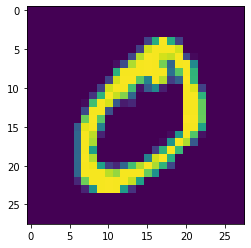

0
8
(256, 28, 28, 1)


In [0]:

data=[[],[],[],[],[],[],[],[],[],[]]

data_y=[[],[],[],[],[],[],[],[],[],[]]

DATA = x_train,y_train

for count in range(DATA[0].shape[0]):
    data[DATA[1][count]].append(DATA[0][count])
    a = np.zeros(shape=(10))
    a[DATA[1][count]] = 1
    data_y[DATA[1][count]].append(a)

plt.imshow(data[0][0].reshape(28,28))
plt.show()
for i in [0,8]:
  print(i)
  data[i] = tf.data.Dataset.from_tensor_slices(data[i])
  data[i] = data[i].repeat().batch(batch_size).prefetch(1)

for fe in data[0].take(1):
  print(np.shape(fe))
  


In [0]:


random_normal = tf.initializers.RandomNormal()
conv_filters= 16, 32, 16

weights = {
    # Conv Layer 1: 5x5 conv, 1 input, 32 filters (MNIST has 1 color channel only).
    'wc1': tf.Variable(random_normal([9, 9, 1, conv_filters[0]])),
    'wc2': tf.Variable(random_normal([5, 5, conv_filters[0], conv_filters[1]])),
    'wc3': tf.Variable(random_normal([3, 3, conv_filters[1], conv_filters[2]])),
    #'wc4': tf.Variable(random_normal([1, 1, conv_filters[2], conv_filters[2]])),
    #'wc4': tf.Variable(random_normal([2, 2, conv_filters[2], conv_filters[3]])),
    # Conv Layer 2: 5x5 conv, 32 inputs, 64 filters.
    #'wct1': tf.Variable(random_normal([2, 2, conv_filters[2], conv_filters[3]])),
    'wct2': tf.Variable(random_normal([3, 3, conv_filters[1], conv_filters[2]])),
    'wct3': tf.Variable(random_normal([5, 5, conv_filters[0], conv_filters[1]])),
    'wct4': tf.Variable(random_normal([9, 9, 1, conv_filters[0]]))
}

biases = {
    'bc1': tf.Variable(tf.zeros([conv_filters[0]])),
    'bc2': tf.Variable(tf.zeros([conv_filters[1]])),
    'bc3': tf.Variable(tf.zeros([conv_filters[2]])),
    #'bc4': tf.Variable(tf.zeros([conv_filters[3]])),
    #'bct1': tf.Variable(tf.zeros([conv_filters[2]])),
    'bct2': tf.Variable(tf.zeros([conv_filters[1]])),
    'bct3': tf.Variable(tf.zeros([conv_filters[0]])),
    'bct4': tf.Variable(tf.zeros([1]))
}


In [0]:
# Create some wrappers for simplicity.
def conv2d(x, W, b, strides=1,padding='SAME', act = tf.nn.sigmoid):
    # Conv2D wrapper, with bias and relu activation.
    x = tf.nn.conv2d(x, W, strides=[1, strides, strides, 1], padding=padding)
    x = tf.nn.bias_add(x, b)
    return act(x)

def conv2d_t(x,W,S, b, k = 2,padding= 'SAME', sig = True, act = tf.nn.sigmoid):
  x = tf.nn.conv2d_transpose(x,W,S,strides=[1, k, k, 1], padding= padding)
  x = tf.nn.bias_add(x,b)
  if sig==True:
    return act(x)
  return x

def maxpool2d(x, k=2):
    # MaxPool2D wrapper.
    return tf.nn.max_pool(x, ksize=[1, k, k, 1], strides=[1, k, k, 1], padding='SAME')
#########
# 신경망 모델 구성
######

def buf(X):
  return tf.nn.top_k(X)


def encoder1(X):
  conv1 = conv2d(X, weights['wc1'], biases['bc1'],8,padding="SAME")
  return conv1
def encoder2(X):
  conv2 = conv2d(X, weights['wc2'], biases['bc2'],4,padding="SAME")
    #conv4 = conv2d(conv3, weights['wc4'], biases['bc4'],2)
  return conv2
def encoder3(X):
  conv3 = conv2d(X, weights['wc3'], biases['bc3'],2,padding="SAME")
  #conv4 = conv2d(conv3, weights['wc4'], biases['bc4'],2)
  return conv3
def decoder1(X):
  decov2 = conv2d_t(X,weights['wct2'],[X.shape[0],X.shape[1]*2 ,X.shape[2]*2, conv_filters[1]],biases['bct2'],k = 2)
  return decov2
def decoder2(X):
  decov3 = conv2d_t(X,weights['wct3'],[X.shape[0],X.shape[1]*4 ,X.shape[2]*4, conv_filters[0]],biases['bct3'],k=4)
  return decov3
def decoder3(X):
  decov4 = conv2d_t(X,weights['wct4'],[X.shape[0],X.shape[1]*8 ,X.shape[2]*8, 1],biases['bct4'],k = 8)
  return decov4

enco =encoder1,encoder2,encoder3
deco =decoder1, decoder2, decoder3 

def E(X,layer = 1):
  for fun in enco[:layer]:
    X = fun(X)
  return X
    
def D(X,layer = 1):
  for fun in deco[len(deco)-layer:]:
    X = fun(X)
  return X

def mean_square(reconstructed, original):
    return tf.reduce_mean(tf.pow(original - reconstructed, 2))
optimizer = tf.optimizers.Adam(learning_rate=learning_rate)

def run_optimization(x,lay = 1):
    # Wrap computation inside a GradientTape for automatic differentiation.
    with tf.GradientTape() as g:
        trainable_variables1=weights['wc1'],biases['bc1'],weights['wct4'],biases['bct4']
        trainable_variables2=weights['wc2'],biases['bc2'],weights['wct3'],biases['bct3']
        trainable_variables3=weights['wc3'],biases['bc3'],weights['wct2'],biases['bct2']
        if lay ==1:
          trainable_variables=trainable_variables1
        if lay ==2:
          trainable_variables=trainable_variables2
        if lay ==3:
          trainable_variables=trainable_variables3
        if lay ==0:
          lay=3
          trainable_variables= trainable_variables2 + trainable_variables3 
        reconstructed_image = D(E(x,lay),lay)
        loss = mean_square(reconstructed_image, x)
    # Variables to update, i.e. trainable variables.
    #print(trainable_variables)
    gradients = g.gradient(loss, trainable_variables)
    
    # Update W and b following gradients.
    optimizer.apply_gradients(zip(gradients, trainable_variables))
    
    return loss

def run_optimization2(x,lay = 1):
    # Wrap computation inside a GradientTape for automatic differentiation.
    with tf.GradientTape() as g:
        trainable_variables1=weights['wc1'],biases['bc1'],weights['wct4'],biases['bct4']
        trainable_variables2=weights['wc2'],biases['bc2'],weights['wct3'],biases['bct3']
        trainable_variables3=weights['wc3'],biases['bc3'],weights['wct2'],biases['bct2']
        if lay ==1:
          trainable_variables=trainable_variables1
          X=x
          reconstructed_image = D(E(x,lay),lay)
        if lay ==2:
          trainable_variables=trainable_variables2
          X = E(x,lay-1)
          reconstructed_image = deco[1](E(x,lay))
        if lay ==3:
          trainable_variables=trainable_variables3
          X = E(x,lay-1)
          reconstructed_image = deco[0](E(x,lay))
        if lay ==0:
          lay=3
          trainable_variables= trainable_variables2 + trainable_variables3
          X=x
          reconstructed_image = D(E(x,lay),lay)
        loss = mean_square(reconstructed_image, X)
    # Variables to update, i.e. trainable variables.
    #print(trainable_variables)
    gradients = g.gradient(loss, trainable_variables)
    
    # Update W and b following gradients.
    optimizer.apply_gradients(zip(gradients, trainable_variables))
    
    return loss


In [0]:
X = x_train[:10]
layer =3
for fun in enco[:layer]:
  X = fun(X)
print(X.shape)
for fun in deco[len(deco)-layer:]:
  X = fun(X)
print(X.shape)

(10, 1, 1, 16)
(10, 64, 64, 1)


layer: 1
step: 0, loss: 0.190804
(1, 64, 64, 1)


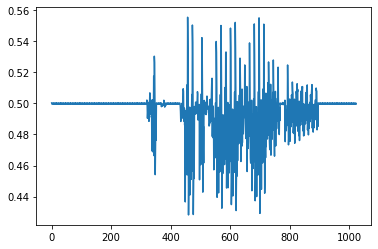

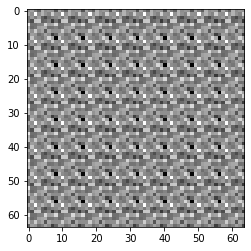

step: 1000, loss: 0.048865
(1, 64, 64, 1)


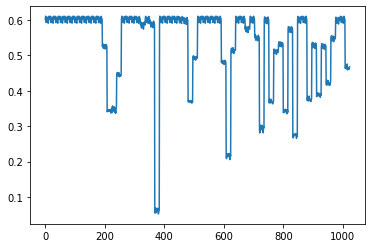

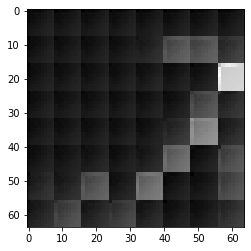

step: 2000, loss: 0.046330
(1, 64, 64, 1)


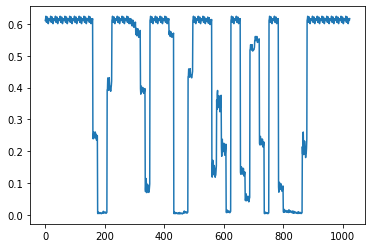

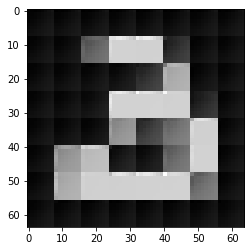

step: 3000, loss: 0.043835
(1, 64, 64, 1)


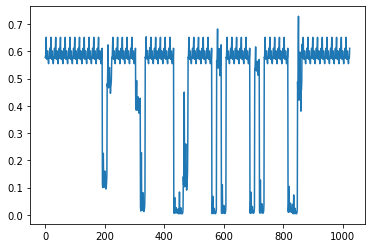

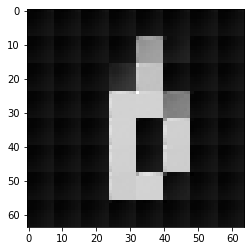

step: 4000, loss: 0.038664
(1, 64, 64, 1)


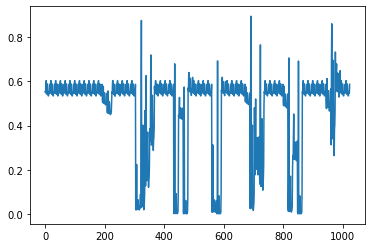

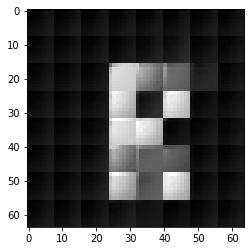

step: 5000, loss: 0.036506
(1, 64, 64, 1)


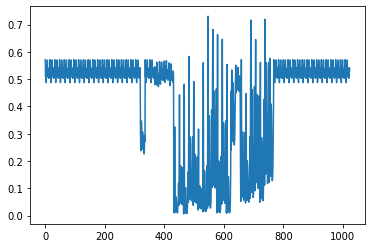

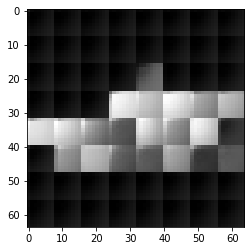

step: 6000, loss: 0.033585
(1, 64, 64, 1)


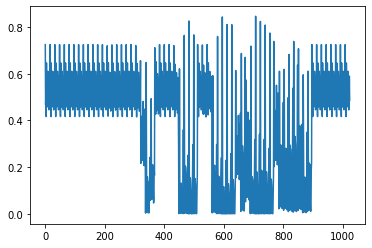

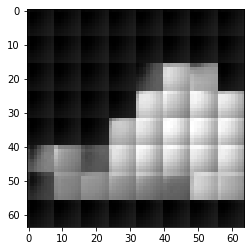

step: 7000, loss: 0.030384
(1, 64, 64, 1)


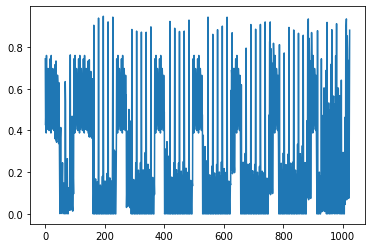

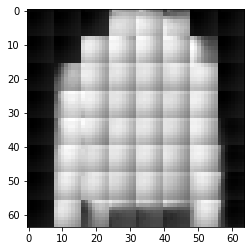

step: 8000, loss: 0.030425
(1, 64, 64, 1)


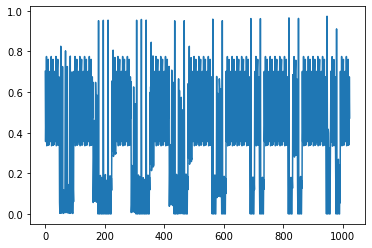

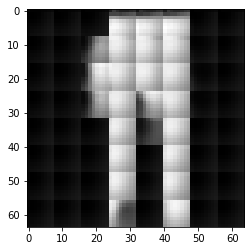

step: 9000, loss: 0.029023
(1, 64, 64, 1)


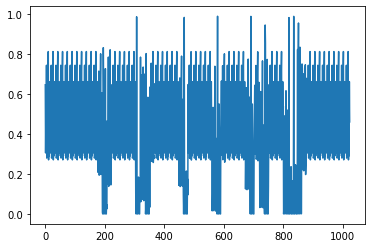

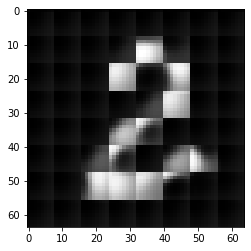

step: 10000, loss: 0.028772
(1, 64, 64, 1)


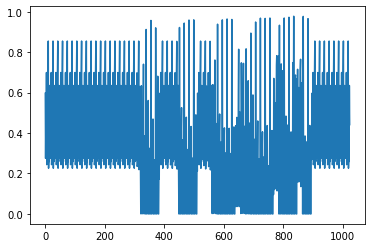

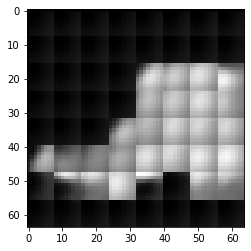

step: 11000, loss: 0.028521
(1, 64, 64, 1)


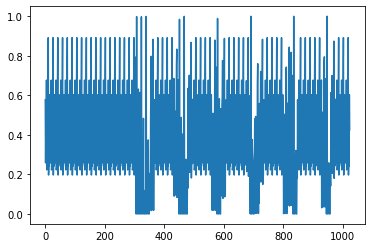

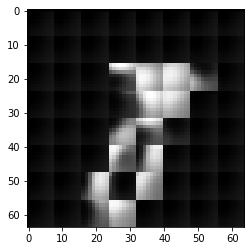

step: 12000, loss: 0.027705
(1, 64, 64, 1)


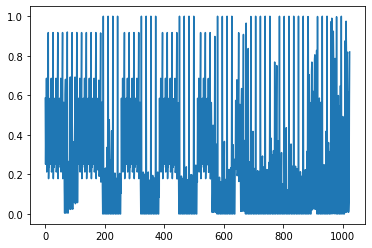

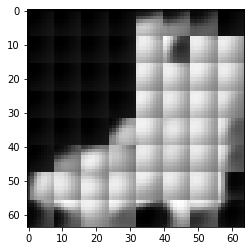

step: 13000, loss: 0.027026
(1, 64, 64, 1)


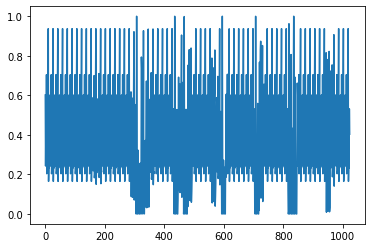

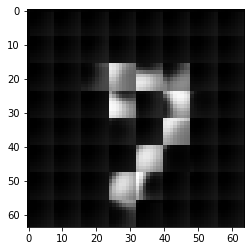

step: 14000, loss: 0.026313
(1, 64, 64, 1)


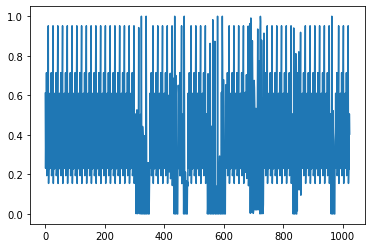

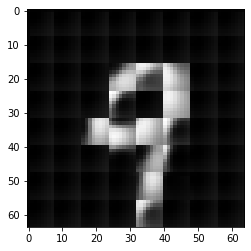

step: 15000, loss: 0.027014
(1, 64, 64, 1)


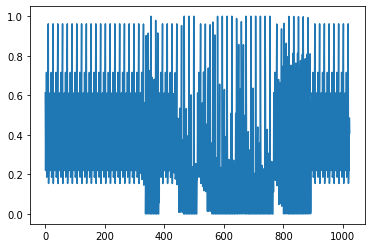

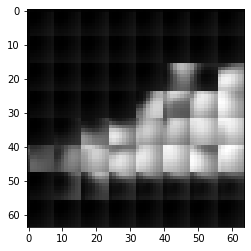

step: 16000, loss: 0.024523
(1, 64, 64, 1)


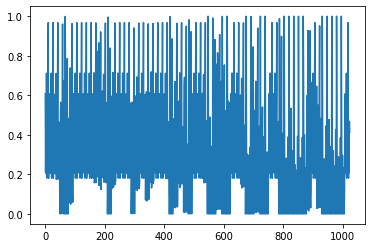

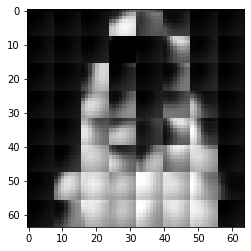

step: 17000, loss: 0.026383
(1, 64, 64, 1)


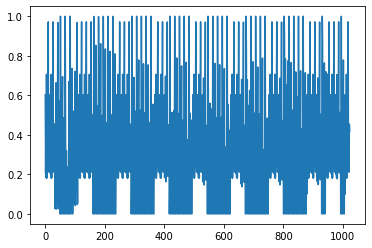

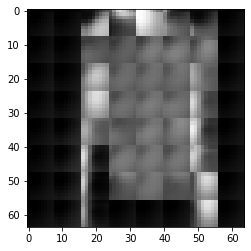

step: 18000, loss: 0.024909
(1, 64, 64, 1)


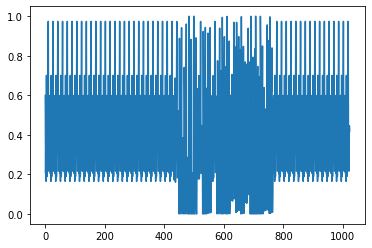

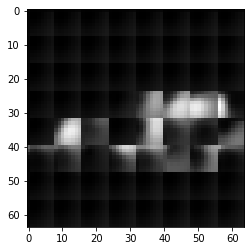

step: 19000, loss: 0.024910
(1, 64, 64, 1)


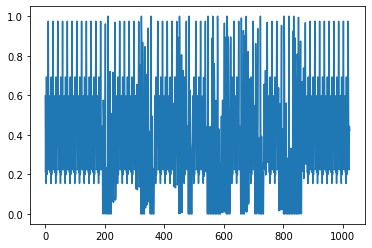

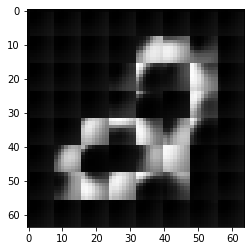

step: 20000, loss: 0.024259
(1, 64, 64, 1)


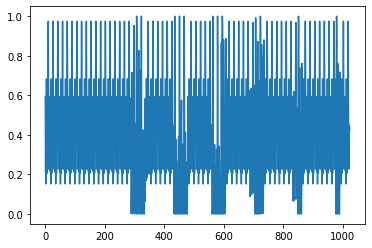

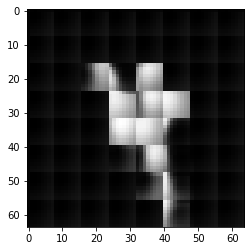

layer: 2
step: 0, loss: 0.144600
(1, 64, 64, 1)


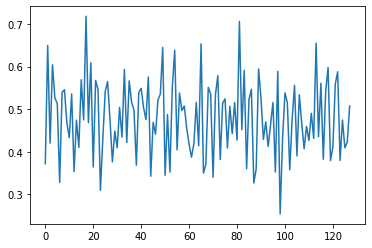

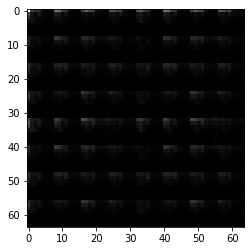

step: 1000, loss: 0.019632
(1, 64, 64, 1)


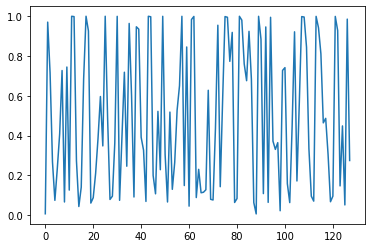

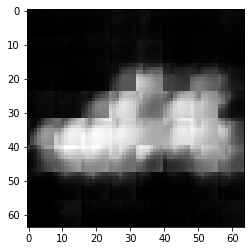

step: 2000, loss: 0.015386
(1, 64, 64, 1)


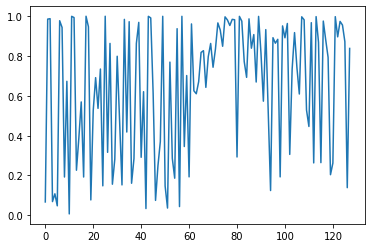

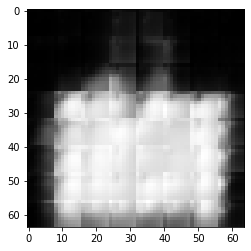

step: 3000, loss: 0.013049
(1, 64, 64, 1)


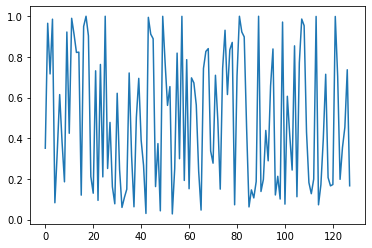

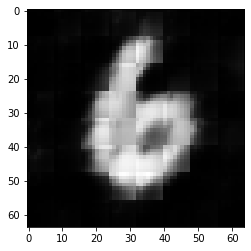

step: 4000, loss: 0.012586
(1, 64, 64, 1)


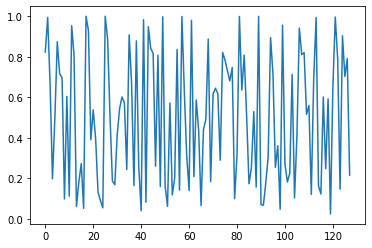

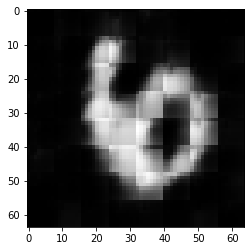

step: 5000, loss: 0.011466
(1, 64, 64, 1)


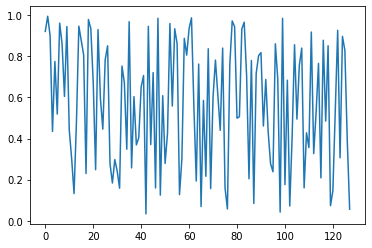

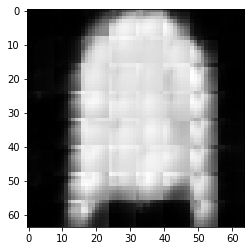

step: 6000, loss: 0.010357
(1, 64, 64, 1)


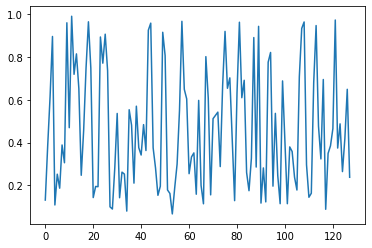

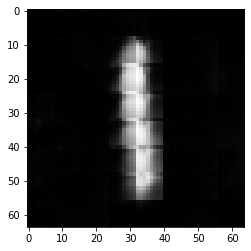

step: 7000, loss: 0.010023
(1, 64, 64, 1)


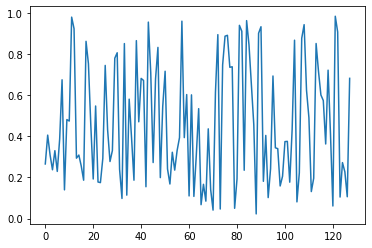

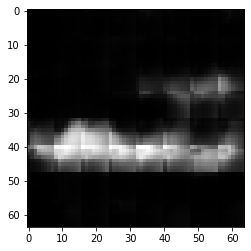

step: 8000, loss: 0.010672
(1, 64, 64, 1)


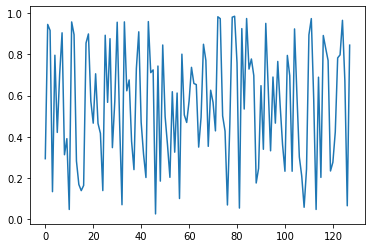

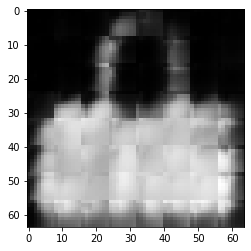

step: 9000, loss: 0.009694
(1, 64, 64, 1)


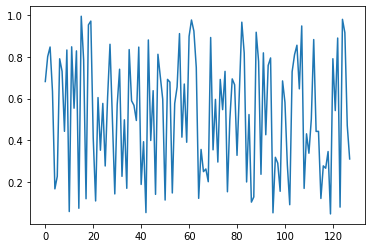

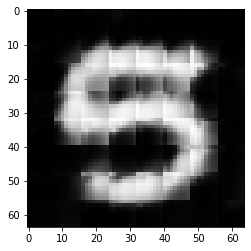

step: 10000, loss: 0.009344
(1, 64, 64, 1)


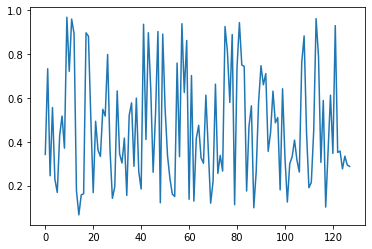

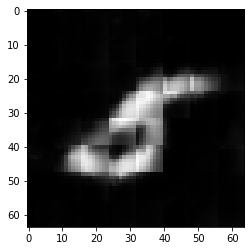

step: 11000, loss: 0.008476
(1, 64, 64, 1)


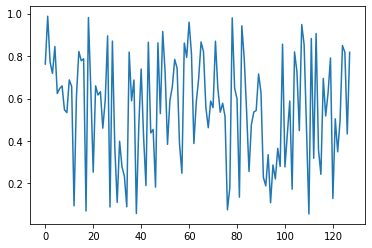

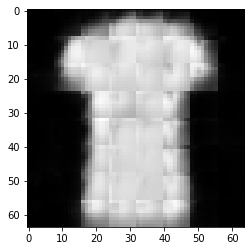

step: 12000, loss: 0.008705
(1, 64, 64, 1)


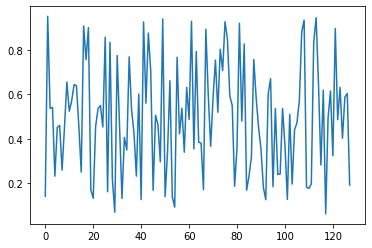

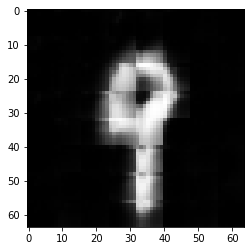

step: 13000, loss: 0.008578
(1, 64, 64, 1)


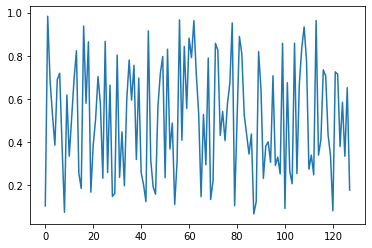

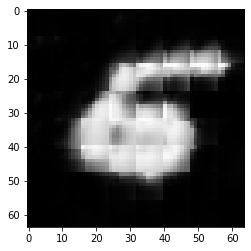

step: 14000, loss: 0.008335
(1, 64, 64, 1)


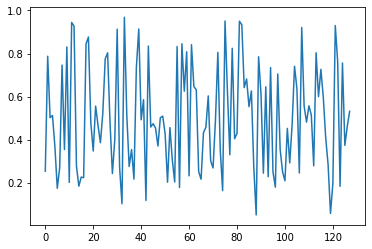

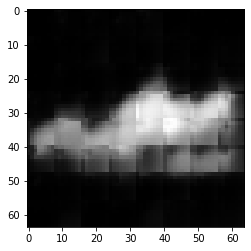

step: 15000, loss: 0.009083
(1, 64, 64, 1)


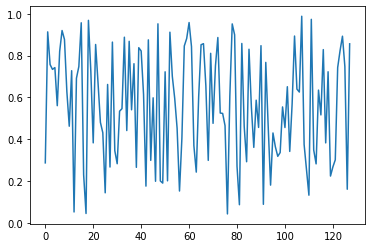

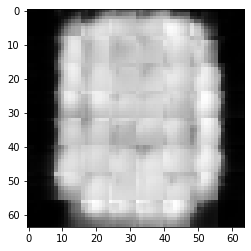

step: 16000, loss: 0.008740
(1, 64, 64, 1)


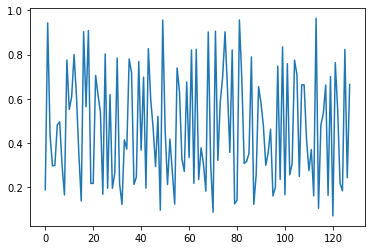

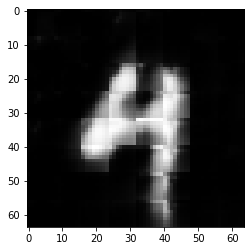

step: 17000, loss: 0.008439
(1, 64, 64, 1)


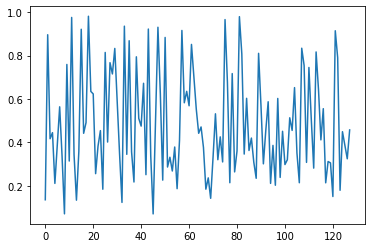

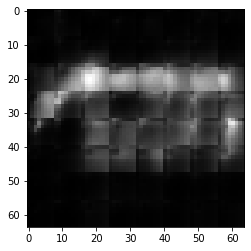

step: 18000, loss: 0.008194
(1, 64, 64, 1)


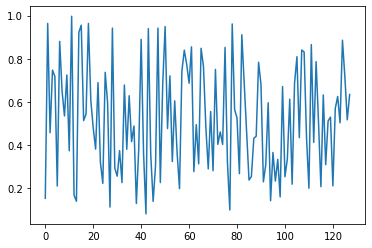

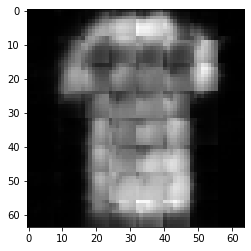

step: 19000, loss: 0.008342
(1, 64, 64, 1)


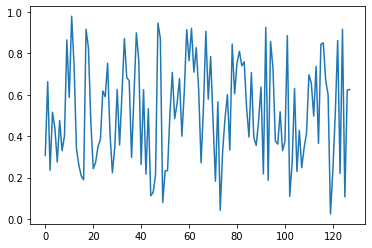

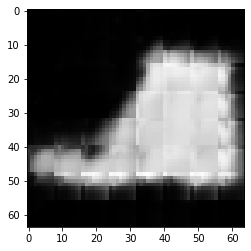

step: 20000, loss: 0.008304
(1, 64, 64, 1)


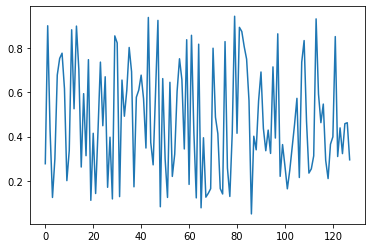

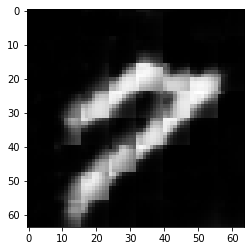

layer: 3
step: 0, loss: 0.116934
(1, 64, 64, 1)


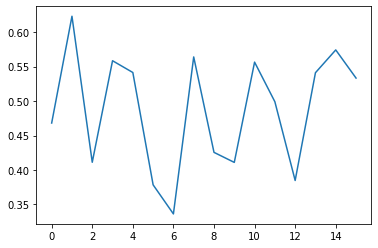

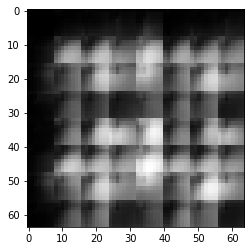

step: 1000, loss: 0.032742
(1, 64, 64, 1)


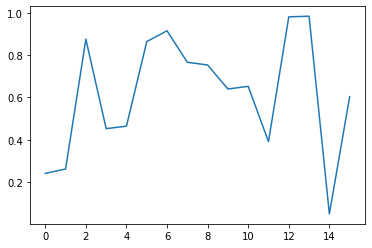

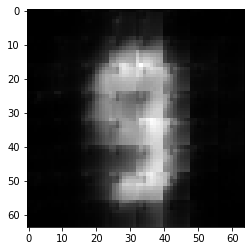

step: 2000, loss: 0.026760
(1, 64, 64, 1)


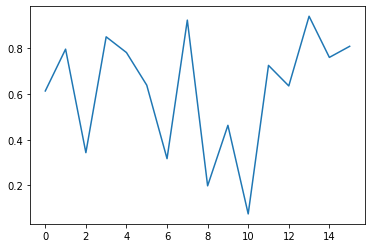

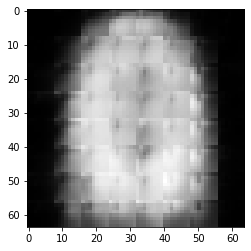

step: 3000, loss: 0.022858
(1, 64, 64, 1)


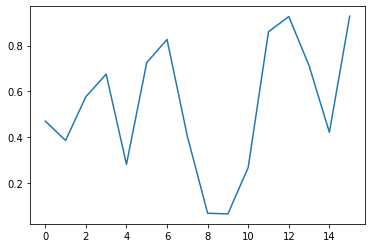

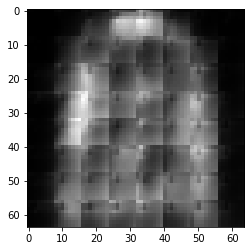

step: 4000, loss: 0.022832
(1, 64, 64, 1)


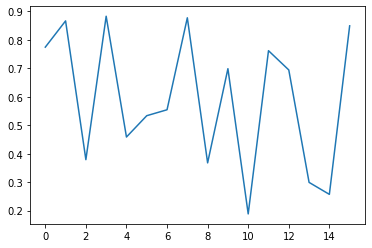

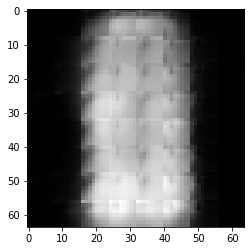

step: 5000, loss: 0.020644
(1, 64, 64, 1)


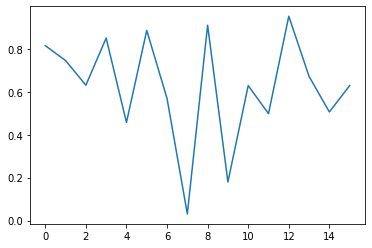

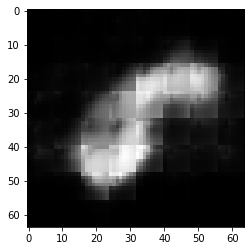

step: 6000, loss: 0.019878
(1, 64, 64, 1)


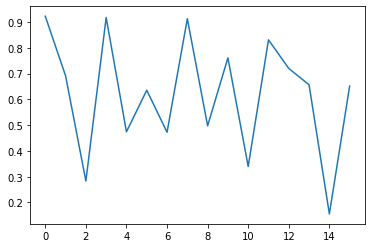

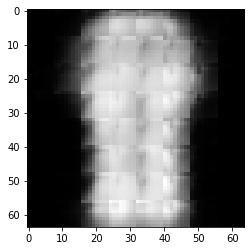

step: 7000, loss: 0.019534
(1, 64, 64, 1)


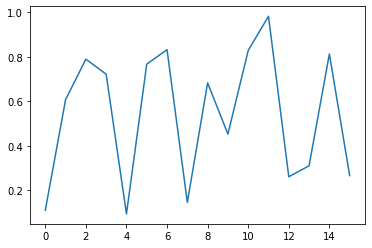

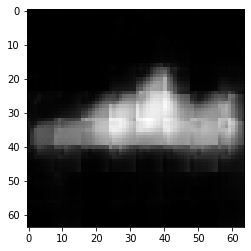

step: 8000, loss: 0.018751
(1, 64, 64, 1)


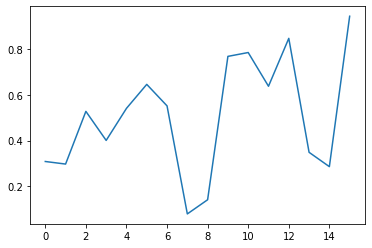

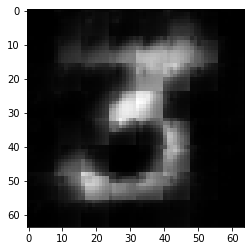

step: 9000, loss: 0.018592
(1, 64, 64, 1)


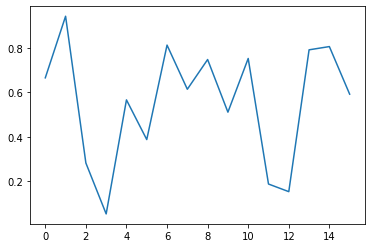

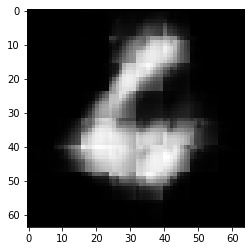

step: 10000, loss: 0.019503
(1, 64, 64, 1)


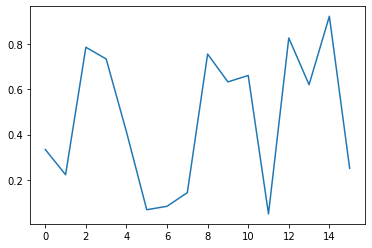

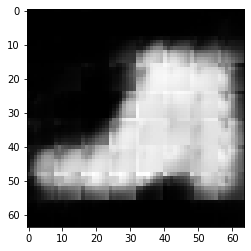

step: 11000, loss: 0.019359
(1, 64, 64, 1)


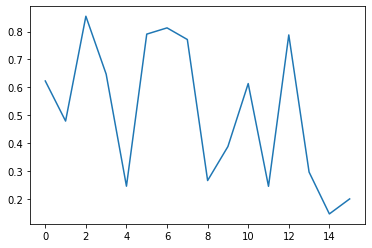

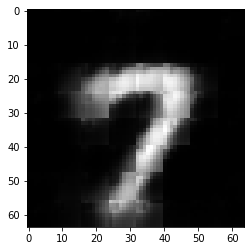

step: 12000, loss: 0.019791
(1, 64, 64, 1)


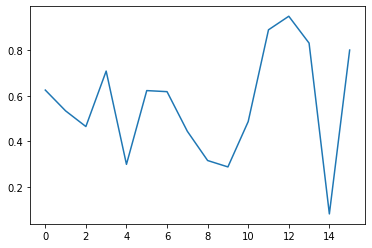

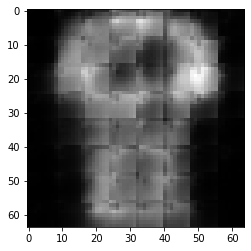

step: 13000, loss: 0.019940
(1, 64, 64, 1)


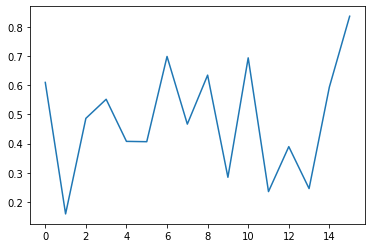

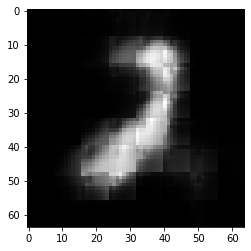

step: 14000, loss: 0.018286
(1, 64, 64, 1)


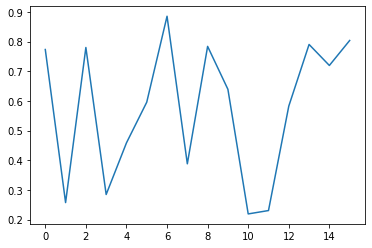

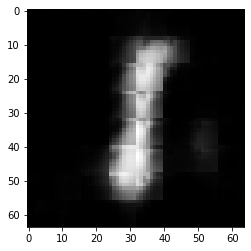

step: 15000, loss: 0.018931
(1, 64, 64, 1)


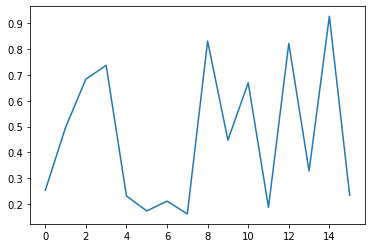

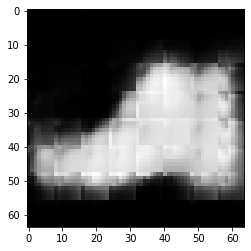

step: 16000, loss: 0.019530
(1, 64, 64, 1)


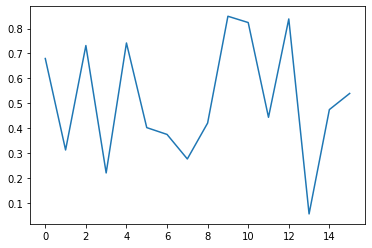

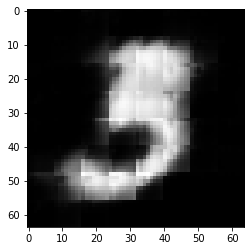

step: 17000, loss: 0.019968
(1, 64, 64, 1)


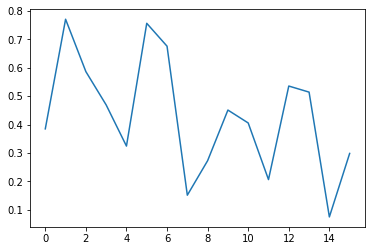

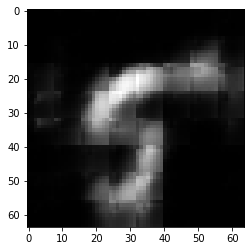

step: 18000, loss: 0.019753
(1, 64, 64, 1)


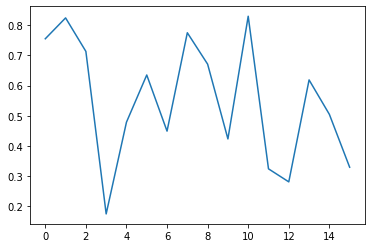

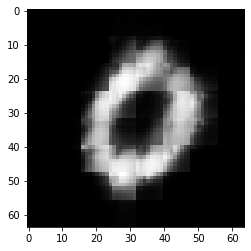

step: 19000, loss: 0.019305
(1, 64, 64, 1)


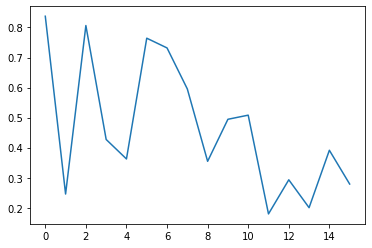

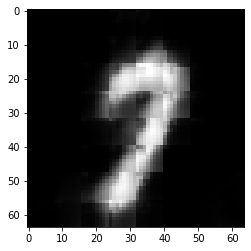

step: 20000, loss: 0.018569
(1, 64, 64, 1)


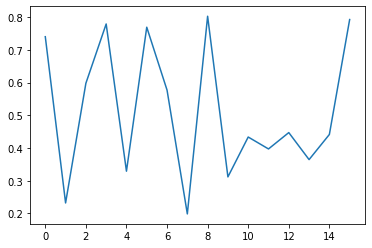

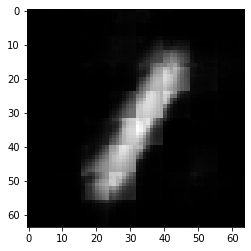

layer: 0
step: 0, loss: 0.018255
(1, 64, 64, 1)


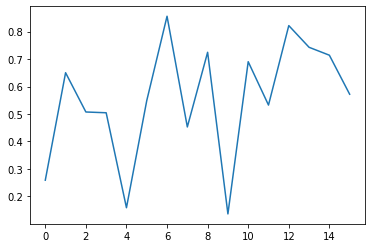

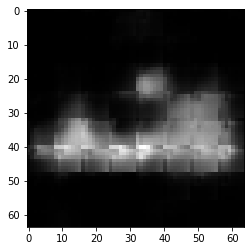

step: 1000, loss: 0.018614
(1, 64, 64, 1)


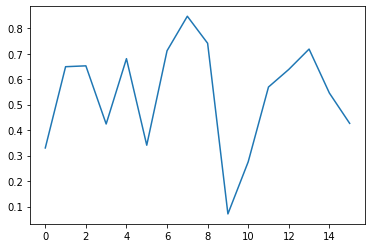

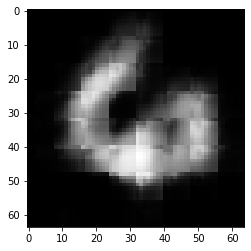

step: 2000, loss: 0.019241
(1, 64, 64, 1)


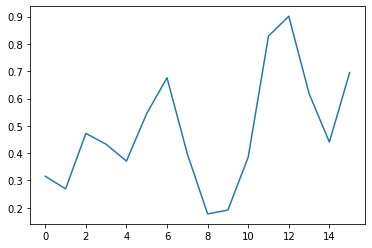

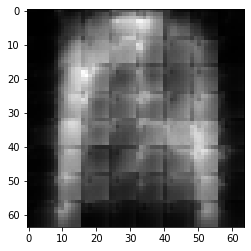

step: 3000, loss: 0.018410
(1, 64, 64, 1)


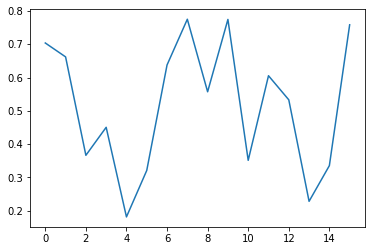

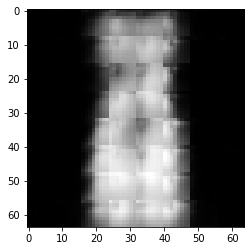

step: 4000, loss: 0.018015
(1, 64, 64, 1)


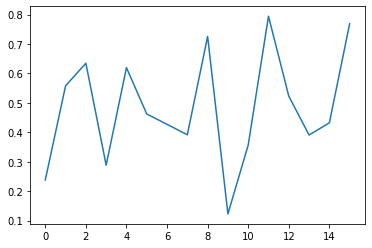

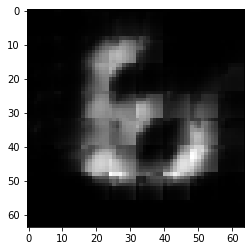

step: 5000, loss: 0.018499
(1, 64, 64, 1)


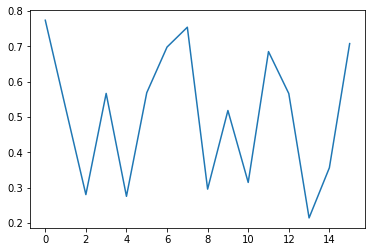

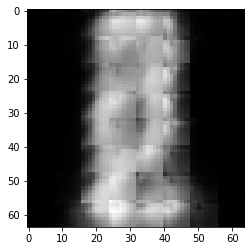

step: 6000, loss: 0.018283
(1, 64, 64, 1)


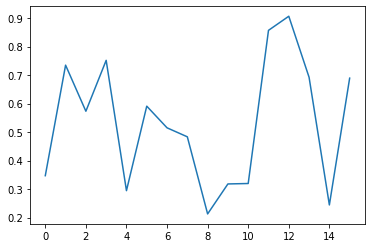

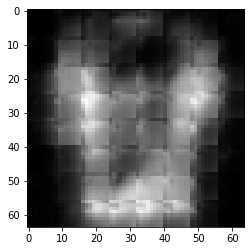

step: 7000, loss: 0.017746
(1, 64, 64, 1)


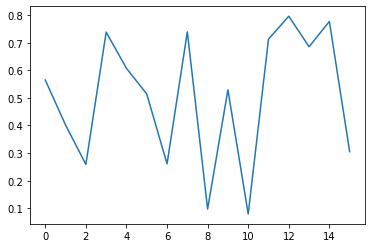

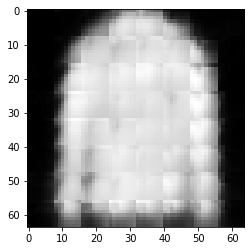

step: 8000, loss: 0.018953
(1, 64, 64, 1)


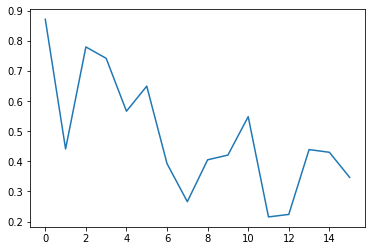

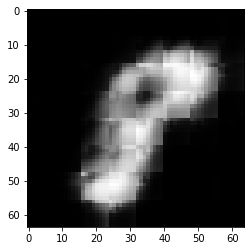

step: 9000, loss: 0.018604
(1, 64, 64, 1)


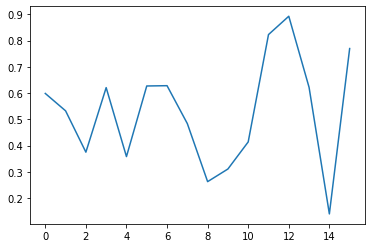

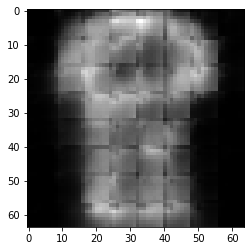

step: 10000, loss: 0.018256
(1, 64, 64, 1)


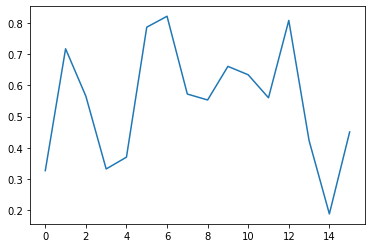

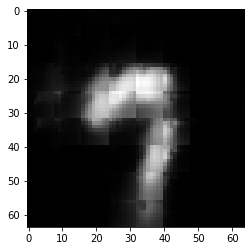

step: 11000, loss: 0.018410
(1, 64, 64, 1)


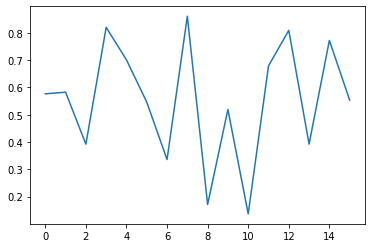

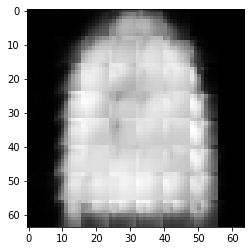

step: 12000, loss: 0.018746
(1, 64, 64, 1)


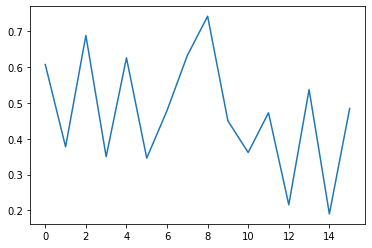

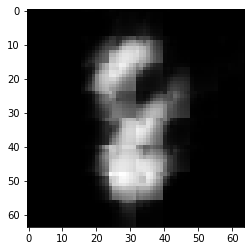

step: 13000, loss: 0.017394
(1, 64, 64, 1)


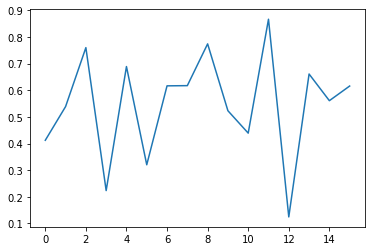

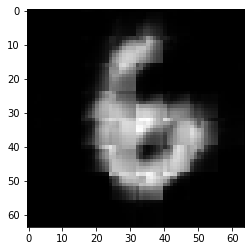

step: 14000, loss: 0.017778
(1, 64, 64, 1)


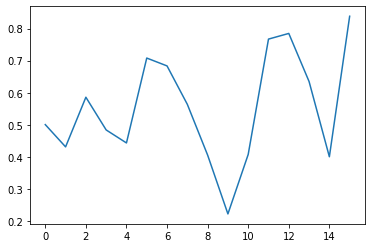

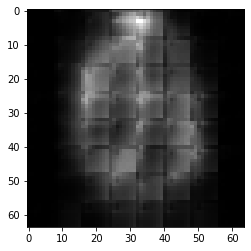

step: 15000, loss: 0.018103
(1, 64, 64, 1)


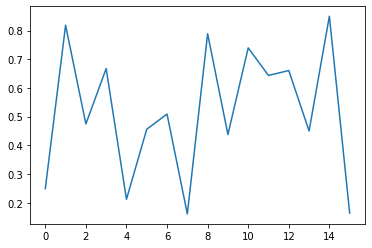

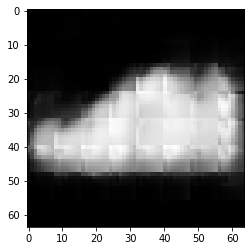

step: 16000, loss: 0.018651
(1, 64, 64, 1)


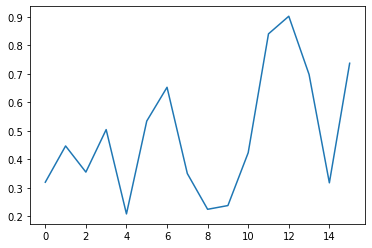

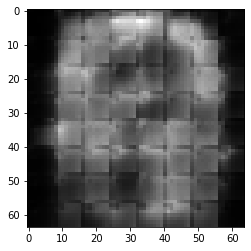

step: 17000, loss: 0.018939
(1, 64, 64, 1)


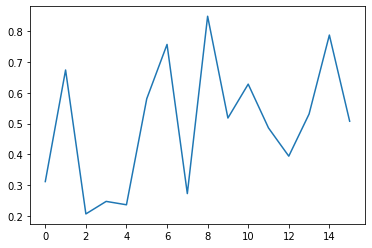

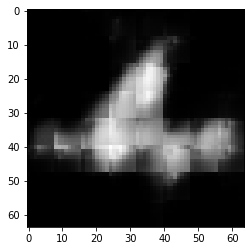

step: 18000, loss: 0.018672
(1, 64, 64, 1)


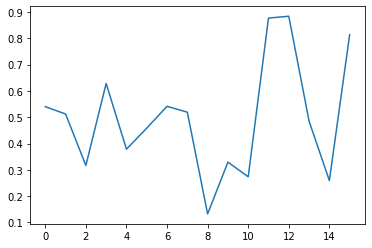

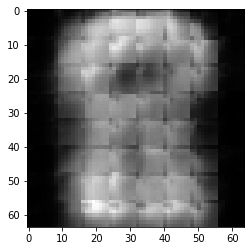

step: 19000, loss: 0.019124
(1, 64, 64, 1)


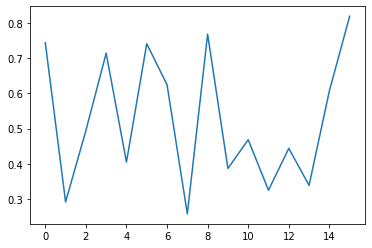

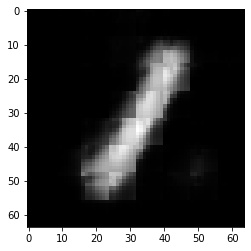

step: 20000, loss: 0.017509
(1, 64, 64, 1)


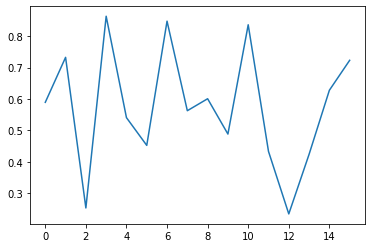

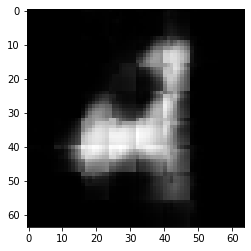

In [0]:
display_step = 1000
training_steps = 20000
# Run training for the given number of steps.

for lay in [1,2,3,0]:
  print("layer:",lay)

  for step, (batch_x, _) in enumerate(train_data.take(training_steps + 1)):
      batch_x = tf.image.resize(batch_x,[si,si])
      loss = run_optimization(batch_x,lay)
      if lay==0:
        lay = 3     
      if step % display_step == 0:
          print("step: %i, loss: %f" % (step, loss))
          reslut_code = batch_x[:1]
          reslut_code=E(reslut_code,lay)
          plt.plot(reslut_code.numpy().reshape([-1]))
          reconstructed_images = D(reslut_code, lay)
          print(reconstructed_images.shape)
          reconstructed_images =reconstructed_images.numpy().reshape([si,si])
          plt.figure("asdf",figsize=(4, 4))
          plt.imshow(reconstructed_images, origin="upper", cmap="gray")
          plt.show()


Original Images


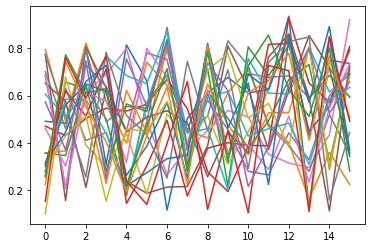

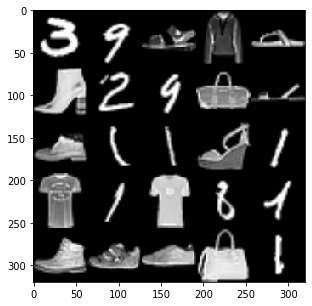

Reconstructed Images


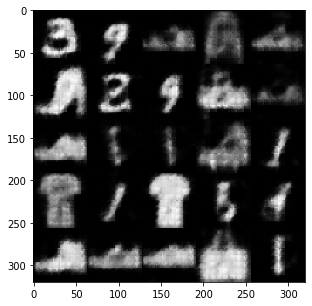

In [0]:

# Encode and decode images from test set and visualize their reconstruction.
n = 5

canvas_orig = np.empty((si * n, si * n))
canvas_recon = np.empty((si * n, si * n))

lay =3

for i, (batch_x,_) in enumerate(train_data.take(n)):
    # Encode and decode the digit image.
    batch_x = tf.image.resize(batch_x,[si,si])
    reconstructed_images = D(E(batch_x,lay),lay)
    # Display original images.
    for j in range(n):
        # Draw the generated digits.
        img = batch_x[j].numpy().reshape([si, si])
        canvas_orig[i * si:(i + 1) * si, j * si:(j + 1) * si] = img
    # Display reconstructed images.
    for j in range(n):
        # Draw the generated digits.
        reconstr_img = reconstructed_images[j].numpy().reshape([si, si])
        #reconstr_img = re[j].reshape([28, 28])
        canvas_recon[i * si:(i + 1) * si, j * si:(j + 1) * si] = reconstr_img
    reslut_code = E(batch_x,lay)
    for j in range(n):
      #print(reslut_code[j].numpy())
      plt.plot(reslut_code[j].numpy().reshape([-1]))



print("Original Images")     
plt.figure(figsize=(n, n))
plt.imshow(canvas_orig, origin="upper", cmap="gray")
plt.show()

print("Reconstructed Images")
plt.figure(figsize=(n, n))
plt.imshow(canvas_recon, origin="upper", cmap="gray")
plt.show()

![대체 텍스트](https://)